# 先抽图像特征再分类
大家都知道看到了，直接用像素和线性分类器，咱们得到的结果并不是那么的理想。<br>
所以这里咱们做个事情，咱们先抽取出一些图像特征，再用这些特征来做图像识别，看看效果是不是提升了。

In [1]:
import random
import numpy as np
from julyedu.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# 载入CIFAR10数据集
from julyedu.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'julyedu/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

In [3]:
from julyedu.features import *

# 这里我们会抽取2种特征，第一是大家熟知的Histogram of Oriented Gradients (HOG)，第二种是HSV空间的颜色信息color_histogram_hsv
#
# 一般数来，HOG会捕获图片的纹理信息，而会忽略颜色信息，所以我们这里的color_histogram_hsv是对颜色的一个补充，我们希望2种信息咱们都能用上。

# 下面的hog_feature和color_histogram_hsv函数都只对一张图片做处理，抽取出相应的特征
# 而extract_features函数是一个批量的操作，得到一个特征矩阵，其中每一行都是对应位置的那张图片抽取出来的特征

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# 依旧要做取均值的处理
mean_feat = np.mean(X_train_feats, axis=1)
mean_feat = np.expand_dims(mean_feat, axis=1)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# 然后咱们得做个标准化了，让所有的特征变化幅度都一致化
std_feat = np.std(X_train_feats, axis=1)
std_feat = np.expand_dims(std_feat, axis=1)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# 再加上我们的bias项
X_train_feats = np.vstack([X_train_feats, np.ones((1, X_train_feats.shape[1]))])
X_val_feats = np.vstack([X_val_feats, np.ones((1, X_val_feats.shape[1]))])
X_test_feats = np.vstack([X_test_feats, np.ones((1, X_test_feats.shape[1]))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [15]:
# 关于学习率和正则化项系数的设定，咱们用交叉验证来选择最佳的参数设定

from julyedu.classifiers.linear_classifier import LinearSVM, Softmax

# 指定一些学习率和正则化系数
learning_rates = [1e-7, 5e-6, 1e-6, 1e-5]
regularization_strengths = [5e4, 1e5, 5e5, 1e6]

results = {}
best_val = -1
best_svm = None

import sys
verbose = True
for lr in learning_rates:
    for reg in regularization_strengths:
        if verbose: sys.stdout.write("Training with hyper parameter learning rate: %e, regularization: %e \n" 
                                     % ( lr, reg ))
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        
        y_train_pred = svm.predict(X_train_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[lr, reg] = (training_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

Training with hyper parameter learning rate: 1.000000e-07, regularization: 5.000000e+04 
Training with hyper parameter learning rate: 1.000000e-07, regularization: 1.000000e+05 
Training with hyper parameter learning rate: 1.000000e-07, regularization: 5.000000e+05 
Training with hyper parameter learning rate: 1.000000e-07, regularization: 1.000000e+06 
Training with hyper parameter learning rate: 5.000000e-06, regularization: 5.000000e+04 
Training with hyper parameter learning rate: 5.000000e-06, regularization: 1.000000e+05 
Training with hyper parameter learning rate: 5.000000e-06, regularization: 5.000000e+05 
Training with hyper parameter learning rate: 5.000000e-06, regularization: 1.000000e+06 
Training with hyper parameter learning rate: 1.000000e-06, regularization: 5.000000e+04 
Training with hyper parameter learning rate: 1.000000e-06, regularization: 1.000000e+05 
Training with hyper parameter learning rate: 1.000000e-06, regularization: 5.000000e+05 
Training with hyper p

In [21]:
# 在测试集上做评估
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.431


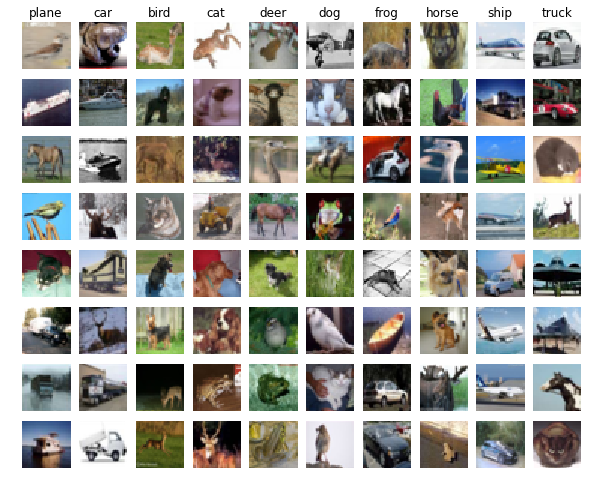

In [18]:
# 每个类别中咱展示出8张图片看看
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()